# Recording flax training on MNIST

The tutorial is taken from https://flax.readthedocs.io/en/v0.5.3/notebooks/annotated_mnist.html
and adapted using the `papyrus`. 

## Imports

In [33]:
import jax
import jax.numpy as jnp                # JAX NumPy

from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers
import tensorflow_datasets as tfds     # TFDS for MNIST


import papyrus as pp
import neural_tangents as nt

## Preparations

In [34]:
class CNN(nn.Module):
    """A simple CNN model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

In [35]:
def cross_entropy_loss(*, logits, labels):
    labels_onehot = jax.nn.one_hot(labels, num_classes=10)
    return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

def accuracy(*, logits, labels):
    predicted_class = jnp.argmax(logits, axis=-1)
    return jnp.mean(predicted_class == labels)
    
def compute_metrics(*, logits, labels):
    loss = cross_entropy_loss(logits=logits, labels=labels)
    acc = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        'loss': loss,
        'accuracy': acc,
    }
    return metrics

In [36]:
def get_datasets(num_samples: int):
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    train_ds['image'] = jnp.float32(train_ds['image']) / 255.
    test_ds['image'] = jnp.float32(test_ds['image']) / 255.

    train_idx = np.random.choice(train_ds['image'].shape[0], num_samples, replace=False)
    test_idx = np.random.choice(test_ds['image'].shape[0], num_samples, replace=False)
    train_ds['image'] = jnp.take(train_ds['image'], train_idx, axis=0)
    train_ds['label'] = jnp.take(train_ds['label'], train_idx, axis=0)
    test_ds['image'] = jnp.take(test_ds['image'], test_idx, axis=0)
    test_ds['label'] = jnp.take(test_ds['label'], test_idx, axis=0)
    
    # Only take a subset of the data
    train_ds = {k: v[:num_samples] for k, v in train_ds.items()}
    return train_ds, test_ds

In [37]:
def create_train_state(rng, learning_rate, momentum):
    """Creates initial `TrainState`."""
    cnn = CNN()
    params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
    tx = optax.sgd(learning_rate, momentum)
    return train_state.TrainState.create(
        apply_fn=cnn.apply, params=params, tx=tx)

In [38]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    def loss_fn(params):
        logits = CNN().apply({'params': params}, batch['image'])
        loss = cross_entropy_loss(logits=logits, labels=batch['label'])
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [39]:
@jax.jit
def eval_step(params, batch):
    logits = CNN().apply({'params': params}, batch['image'])
    return compute_metrics(logits=logits, labels=batch['label'])

## Instantiate Recorders

In [40]:
# Create Measurements

loss = pp.measurements.Loss(name='loss')
acc = pp.measurements.Accuracy(name='accuracy')

trace = pp.measurements.NTKTrace(name='trace')
self_entropy = pp.measurements.NTKSelfEntropy(name='self_entropy')
entropy = pp.measurements.NTKEntropy(name='entropy')

# Set up NTK computation
ntk_fn = nt.batch(nt.empirical_ntk_fn(CNN().apply, trace_axes=(), vmap_axes=0), batch_size=32)
# ntk_fn = nt.empirical_ntk_fn(CNN().apply, trace_axes=())

# Test NTK computation
cnn = CNN()
rng = jax.random.PRNGKey(0)
params = cnn.init(rng, jnp.ones([2, 28, 28, 1]))
x = jnp.ones([2, 28, 28, 1])
test_ntk = ntk_fn(x, None, params)
assert test_ntk.shape == (2, 2, 10, 10)

/Users/konstantinnikolaou/Applications/miniconda3/envs/jax/lib/python3.11/site-packages/neural_tangents/_src/batching.py:658: UserWarning: Batch size is reduced from requested 32 to effective 2 to fit the dataset.
  warnings.warn(


In [41]:
# Create Recorders

# Create temporary storage directory
import os 

# Remove old directory if it exists
os.system('rm -rf temp/')

os.mkdir('temp/')
storage_dir = 'temp/'

train_recorder = pp.recorders.BaseRecorder(
    name='train_recorder',
    storage_path=storage_dir,
    chunk_size=20, 
    measurements=[loss, acc, trace, self_entropy, entropy]
)
test_recorder = pp.recorders.BaseRecorder(
    name='test_recorder',
    storage_path=storage_dir,
    chunk_size=2, 
    measurements=[loss, acc]
)

In [42]:
def test_eval(params, test_ds, epoch):
    metrics = eval_step(params, test_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree_map(lambda x: x.item(), metrics)
    test_recorder.record(
        neural_state={'loss': [summary['loss']], 'accuracy': [summary['accuracy']]}, epoch=epoch)
    return summary['loss'], summary['accuracy']


def train_eval(params, train_ds, epoch):
    # Compute NTK measurements
    metrics = eval_step(params, train_ds)
    batch_ntk = ntk_fn(train_ds['image'], None, {'params': params})
    flat_batch_ntk, _ = pp.utils.flatten_rank_4_tensor(batch_ntk)
    neural_state = {
        "loss": [metrics['loss']], 
        "accuracy": [metrics['accuracy']], 
        "ntk": [flat_batch_ntk]
    }
    # Record measurements
    train_recorder.record(epoch=epoch, neural_state=neural_state)
    return metrics

In [43]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
    """Train for a single epoch."""
    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    batch_metrics = []
    batch_idx = 0
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state = train_step(state, batch)
        metrics = train_eval(state.params, batch, batch_idx)
        batch_metrics.append(metrics)
        batch_idx += 1

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]}

    print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
        epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

    return state

In [45]:
train_ds, test_ds = get_datasets(num_samples=5000)

In [46]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

In [47]:
learning_rate = 0.1
momentum = 0.9

In [48]:
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [49]:
num_epochs = 10
batch_size = 32

In [50]:
train_recorder.neural_state_keys

['accuracy', 'ntk', 'loss']

In [51]:
for epoch in range(1, num_epochs + 1):
    # Use a separate PRNG key to permute image data during shuffling
    rng, input_rng = jax.random.split(rng)
    # Run an optimization step over a training batch
    state = train_epoch(state, train_ds, batch_size, epoch, input_rng)
    # Evaluate on the test set after each training epoch 
    test_loss, test_accuracy = test_eval(state.params, test_ds, epoch)
    # train_eval(state.params, train_ds, epoch)
    print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
        epoch, test_loss, test_accuracy * 100))

Storing data...
Data stored.


KeyboardInterrupt: 

## Load the data

In [20]:
# Load the recorded data

train_result = train_recorder.load()
test_result = test_recorder.load()

In [21]:
import matplotlib.pyplot as plt

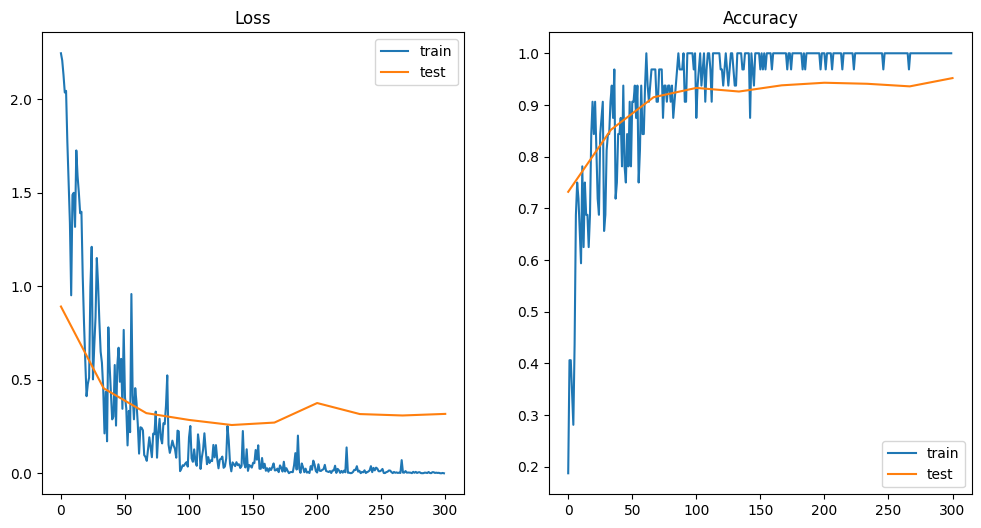

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(train_result['loss'], label='train')
train_len = len(train_result['loss'])
test_len = len(test_result['loss'])
ax[0].plot(np.linspace(0, train_len, test_len), test_result['loss'], label='test')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(train_result['accuracy'], label='train')
ax[1].plot(np.linspace(0, train_len, test_len), test_result['accuracy'], label='test')
ax[1].set_title('Accuracy')
ax[1].legend()

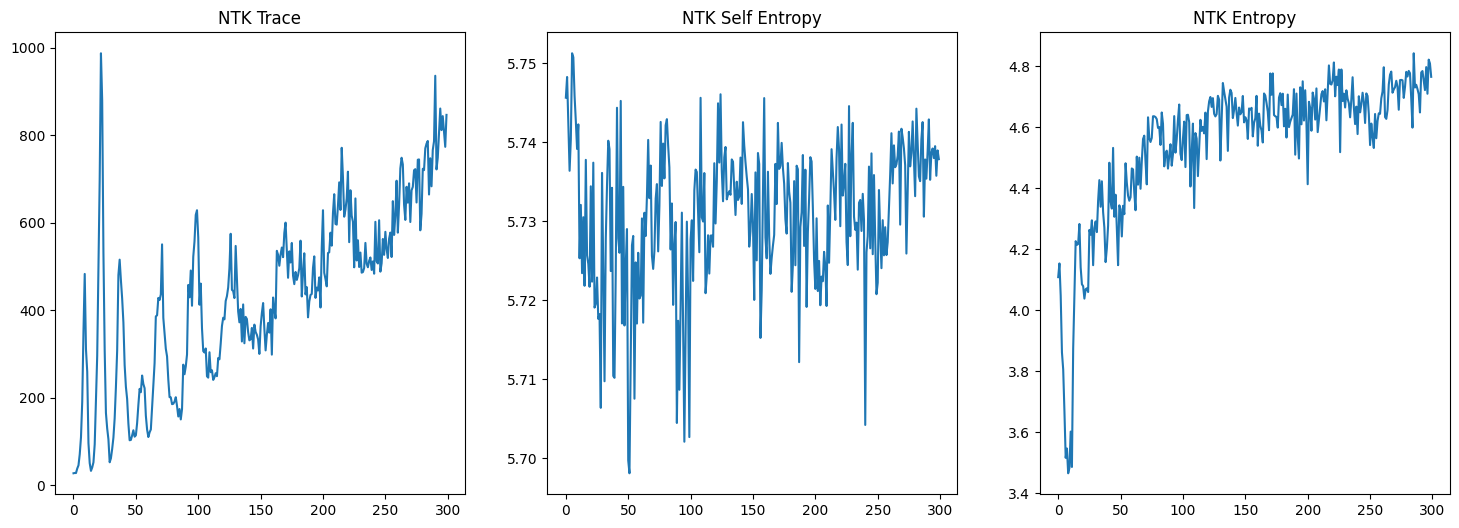

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(train_result['trace'])
ax[0].set_title('NTK Trace')

ax[1].plot(train_result['self_entropy'])
ax[1].set_title('NTK Self Entropy')

ax[2].plot(train_result['entropy'])
ax[2].set_title('NTK Entropy')

plt.show()


In [ ]:
# Clean the temporary storage directory

os.rmdir('temp/')